# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 3: RNN и языковые модели 

### Общая информация
### Оценивание и штрафы

Максимально допустимая оценка за работу — 10 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит обучить рекуррентную нейронную сеть для задачи генерации текстов. В качестве данных возьмем набор из 120 тысяч анекдотов (всех категорий от А до Я включительно). Его вы можете найти в архиве `jokes.txt.zip`, который доступен по [ссылке](https://disk.yandex.com/d/fjt5xICH-ukEEA).

In [1]:
%load_ext autoreload
%autoreload 2

## Задание 1: Dataset (1 балл)

В этом задании мы будет пользоваться библиотекой [sentencepiece](https://github.com/google/sentencepiece), которая поддерживает разные форматы токенизации текстов, в том числе BPE, который мы и будем использовать. Реализуйте недостающие фрагменты кода в классе `TextDataset` в файле `dataset.py`. Датасет обучает sentencepiece токенизатор, токенизирует тексты, превращает токены в индексы и паддит до одной и той же длины (параметр `max_length`). Не забудьте, что для генерации текстов нам будут нужны специальные токены начала и конца последовательности, соответственно `BOS` и `EOS`. Существуют еще два специальных токена &mdash; паддинг `PAD` и токен `UNK`, заменяющий out-of-vocabulary токены.

In [2]:
!pip install sentencepiece


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import torch
import numpy as np
from dataset import TextDataset

In [4]:
train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe')
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe')

In [5]:
# Код должен проходить тесты
assert len(train_set) + len(valid_set) == 120759

for _ in range(5):
    for dataset in (train_set, valid_set):
        indices, length = dataset[np.random.randint(len(dataset))]
        assert indices.shape == (dataset.max_length, )
        assert indices[0].item() == dataset.bos_id
        assert (indices == dataset.eos_id).sum().item() == 1

        eos_pos = indices.tolist().index(dataset.eos_id)
        assert torch.all(indices[eos_pos + 1:] == dataset.pad_id)
        assert (indices != dataset.pad_id).sum() == length

## Задание 2 Language model (3.5 балла)

Реализуйте класс `LanguageModel` из файла `model.py`. Мы будем генерировать текст с помощью языковой модели &mdash; это авторегрессионная вероятностная модель, которая предсказывает распределение следующего токена при условии предыдущих:

$$
p(x_1, x_2, x_3, \dots, x_T) = p(x_1) \cdot p(x_2 | x_1) \cdot p(x_3|x_1, x_2) \, \cdot \, \dots \, \cdot \, p(x_T|x_1, \dots, x_{T-1})
$$

Мы будем реализовывать ее с помощью рекуррентной нейронной сети. Ваш код должен поддерживать возможность работать как с оригинальной [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN), так и c [LSTM](https://bitly.com/98K8eH). На каждом временном шаге модель возвращает логиты вероятностей для следующего токена. Модель будет работать в двух режимах (не путать с `.train()` и `.eval()`):

- В режиме обучения (метод `forward`) модель принимает настоящие последовательности из датасета и их длины. На каждом временном шаге возвращаются логиты вероятностей следующего токена, что позволяет считать лосс, обучаться на трейне и валидироваться на валидации.

- В режиме генерации (инференса, метод `inference`) модель принимает некоторый префикс (возможно пустой), с которого начинать генерацию, и продолжает его. Для этого на каждом шаге генерируются новые логиты, семплируется новый токен (из распределения, заданного логитами), и процесс продолжается, пока не будет сгенерирован токен `EOS` или не будет достигнуто ограничение на длину последовательности. **Обратите внимание**, что вам не нужно прогонять всю последовательность заново через RNN после каждого нового токена, это приведет к квадратичной сложности по длине последовательности. Вам достаточно обновлять скрытое состояние, подавая на вход новый сгенерированный токен и предыдущее скрытое состояние. Кроме того, чтобы получить больше контроля над генерацией, вводится параметр температуры `temp`. Перед семплированием нужно разделить на него логиты, полученные моделью. 

In [4]:
from model import LanguageModel

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [8]:
model = LanguageModel(train_set)

In [9]:
# Код должен проходить тесты
for bs in [1, 4, 16, 64, 256]:
    indices = torch.randint(high=train_set.vocab_size, size=(bs, train_set.max_length))
    lengths = torch.randint(low=1, high=train_set.max_length + 1, size=(bs, ))
    logits = model(indices, lengths)
    assert logits.shape == (bs, lengths.max(), train_set.vocab_size)

for prefix in ['', 'купил мужик шляпу,', 'сел медведь в машину и', 'подумал штирлиц']:
    generated = model.inference(prefix, temp=np.random.uniform(0.1, 10))
    assert type(generated) == str
    print(generated)
    assert generated.startswith(prefix)


купил мужик шляпу,хи официа кажды имен правильно интересно их который строройкахнытелььезываетбить чет позра время ненисовдают откудасу объяс прязе часалить обяза ро полуряд ваша греноги сре сын наш 2 всегдарод большешатьдомтельнопе единнныйсать моск нашнт сказала выглялуентацасила позво эквая временинынидцать напоспорбен заходит сейчас инзуситрь борительно восдить наши пенси хорошо потому окров работа му бумаите простолуж еще говорит вообщетель сол краснибудьдравпе мозвить иногда одна успебе жизни какиезатьшел навер спор дело внима втоняяви а долла соб зем идет пом кажетсярияциа угоходит сланулвати плольный куриписа ра вашиля сво жену развежновилмот поста приветлекеском ис мальчичные полу вечером студенятсячегоит последев есть пь ох зоситьхистрепар шерилбтер четырежддни раза любилинетесят неде россия смо постели этотзиденкам там твоика предлотерарок учью дела дере понялить приговтра дете дура- смер своеходи сооб убеение выпу бы можетдешь делает волтичериа всюнулвшивой сам неде прекра

## Задание 3: Training (1.5 балла)

Всё, что нам осталось &mdash; реализовать цикл обучения. Заполните пропуски в файле `train.py`. Не забудьте, что мы учим модель предсказывать вероятность следующего, а не текущего токена. Также рекомендуется обрезать батч индексов по самой длинной последовательности, чтобы не гонять паддинги вхолостую. Для оценки качества генерации будем использовать метрику [perplexity](https://towardsdatascience.com/perplexity-in-language-models-87a196019a94). Реализуйте ее подсчет в функции `plot_losses` (да, для этого достаточно только значения лосса).

Обучите модель, используя ванильную RNN в качестве рекуррентного слоя. Сохраните чекпойнт обученной модели, он нам еще пригодится. 

In [6]:
import torch.optim as optim
from torch.utils.data import DataLoader
from train import train

In [11]:
learning_rate = 0.001
batch_size = 32
num_epochs = 10

In [12]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

In [13]:
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valid_set, batch_size=batch_size)

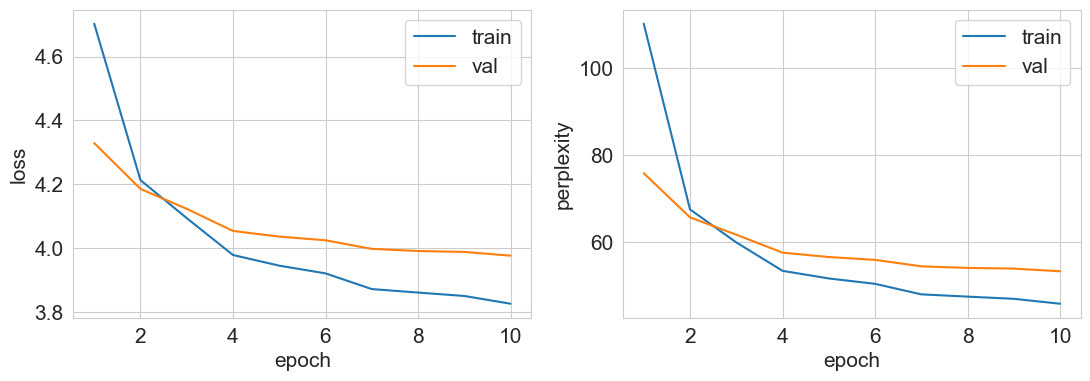

In [14]:
train(
    model, 
    optimizer, 
    scheduler, 
    train_loader, 
    val_loader, 
    num_epochs=num_epochs, 
    device=device
)

In [15]:
torch.save(model, "./rnn_model.pt")

## Задание 4: LSTM (0.5 балла)

Обучите аналогичную модель, но с LSTM в качестве рекуррентного слоя. Сравните модели по метрикам и генерации. Не забывайте про чекпойнты!

In [7]:
from torch import nn

In [17]:
learning_rate = 0.001
batch_size = 32
num_epochs = 10

In [18]:
model_lstm = LanguageModel(train_set, rnn_type=nn.LSTM)

In [19]:
optimizer = optim.Adam(model_lstm.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

In [20]:
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valid_set, batch_size=batch_size)

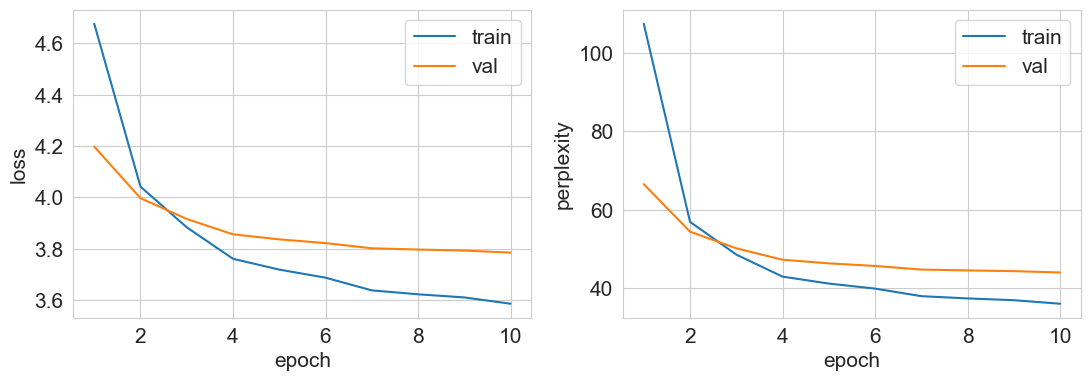

In [21]:
train(
    model_lstm, 
    optimizer, 
    scheduler, 
    train_loader, 
    val_loader, 
    num_epochs=num_epochs, 
    device=device
)

In [22]:
torch.save(model_lstm, "./lstm_model.pt")

In [48]:
prefix_fail = "Штирлец провалился"

In [49]:
model = torch.load("rnn_model.pt").to(torch.device("cpu"))

In [55]:
model.inference(prefix_fail)

'штирлец провалился, посмотрел в карантиновку.'

In [51]:
model.inference(prefix_fail)

'штирлец провалился, он отравился от коньяка и колопевь стентя, не идеализма гузурд, да еще в смысле.'

In [53]:
model.inference(prefix_fail)

'штирлец провалился в работу.разь собчает, что уже прежной голоса.'

In [56]:
model_lstm = torch.load("lstm_model.pt").to(torch.device("cpu"))

In [62]:
model_lstm.inference(prefix_fail)

'штирлец провалился быстрее. женщинам у головы, для радостиска крапуты отвлекала.'

In [46]:
model_lstm.inference(prefix_fail)

'штирлец провалился, сынок как связь.'

In [47]:
model_lstm.inference(prefix_fail)

'штирлец провалился в очередь пропорционального миру!'

 - После изменения с RNN на LSTM, метрика улучшилась на ~18%, так как perplexity с ~55 уменьшилось до ~45 на val выборке;
  - Генерации обеих моделей бессмысленны: слова зачастую исковерканы, слова между собой бессвязны, префикс и его продолжение между собой не связаны.

## Задание 5: Sampling temperature (0.5 балла)

Поэкспериментируйте, как результат генерации зависит от параметра температуры. Попробуйте генерацию с разными префиксами. Сделайте выводы. 

In [63]:
model_lstm = torch.load("lstm_model.pt").to(torch.device("cpu"))

### Prefix - муж

In [64]:
prefix_husband = "Муж, провожая жену в командировку"

In [65]:
model_lstm.inference(prefix_husband, temp=0.001)

'муж, провожая жену в командировку, сижу, думаю как не пойдет его лапвых носки, которая уже вызывал.'

In [66]:
model_lstm.inference(prefix_husband, temp=0.1)

'муж, провожая жену в командировку, как быть жестанки, что это заключается с иадеквари?'

In [67]:
model_lstm.inference(prefix_husband, temp=5)

'муж, провожая жену в командировку метро и стакан, и дети, а куда они наветерический любые, ели орда будет очень проходите в неудержатский должок за один я и тогда а что.'

In [68]:
model_lstm.inference(prefix_husband, temp=25)

'муж, провожая жену в командировку жизненными. так же можно знать, сколько в вашем организме, чтобы не оказывать посутить!'

In [69]:
model_lstm.inference(prefix_husband, temp=100)

'муж, провожая жену в командировкулемовшегося итали во время бабой.'

### Prefix - экономический рывок

In [70]:
prefix_eco = "Экономический рывок был настолько мощным"

In [71]:
model_lstm.inference(prefix_eco, temp=0.001)

'экономический рывок был настолько мощным, дорогая, когда дочка во есть кого-то по в жениху.'

In [72]:
model_lstm.inference(prefix_eco, temp=0.1)

'экономический рывок был настолько мощным, что меня интересная сдачи не достоверновей падает.'

In [73]:
model_lstm.inference(prefix_eco, temp=5)

'экономический рывок был настолько мощным слепой.'

In [74]:
model_lstm.inference(prefix_eco, temp=25)

'экономический рывок был настолько мощным пожарником готовит, а вторые-таки, никого не согласен.'

In [75]:
model_lstm.inference(prefix_eco, temp=100)

'экономический рывок был настолько мощнымведением рабочий выше, чем назоран до тех.'

### Prefix - Лада

In [76]:
prefix_lada = "Купил мужик себе Ладу Калину"

In [77]:
model_lstm.inference(prefix_lada, temp=0.001)

'купил мужик себе ладу калину, а ты не жалеешь...'

In [78]:
model_lstm.inference(prefix_lada, temp=0.1)

'купил мужик себе ладу калину, достал стоинчку и увидел по вкусу. двойник... нет, он иногда хотят сделать, но и то...- ладно, к вам можно с гармы серетой...'

In [79]:
model_lstm.inference(prefix_lada, temp=5)

'купил мужик себе ладу калину дополнительный, генеральеру и жизнь боится новая стенеджна, чтобы приятное большую практичный песок и по подбегает. мимо жере окно, для вас в обступили.'

In [80]:
model_lstm.inference(prefix_lada, temp=25)

'купил мужик себе ладу калину1 африки в одном случае? это бессмерт!- почему же в вопросах есть?- нет.- но вы не знаете такое же, возможно, вы еще не ест на войну те?- вырубать.- ага, зритель то! но для кого-нибудь приносит слово.- отлично, ты его бегал стал...'

In [81]:
model_lstm.inference(prefix_lada, temp=100)

'купил мужик себе ладу калину советские церквик - это страшношира.- конкретно на переджимании - так нет муму.'

- Температура 0.001: Результаты генерации бессмысленные, тексты получаются небольшими;
- Температура 0.1: Результаты начинают показывать немного больше разнообразия, но все еще остаются довольно бессмысленными;
- Температура 5: Тексты разнообразнее, но начинают все больше терять логическую связность (больше хаоса), слова искажаются;
- Температура 25, 100: Результаты генерации очень хаотичные и бессмысленные, стали появляться лишние символы (например, .- посреди текста).

По итогу, модель генерирует бессмысленные тексты вне зависимости от температуры. Чем больше температуры, тем хаотичнее получается текст и с большей вероятностью получается длинные ответы с искаженными словами и лишними символами. Оптимальной температурой можно считать 0.1 и 0.001. 

## Задание 6: Tokenizers (1 балл)

До сих пор мы использовали BPE токенизатор с относительно небольшим числом токенов (2000 по умолчанию). Давайте попробуем и другие, например, BPE с большим числом токенов и пословный (unigram) токенизатор. Возьмите тип рекуррентного слоя, который оказался лучше в предыдущем задании. Обучите модели на таких токенизаторах и сравните их генерацию. Не забывайте сохранять чекпойнты. Правильно ли сравнивать между собой получившиеся модели по значению perplexity? Почему?

### BPE - 10000 vocab

In [82]:
train_set_bpe_large = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe_10000', vocab_size=10000)
valid_set_bpe_large = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe_10000', vocab_size=10000)

In [83]:
model_bpe_large = LanguageModel(train_set_bpe_large, rnn_type=nn.LSTM)

In [84]:
learning_rate = 0.001
batch_size = 32
num_epochs = 10

In [85]:
optimizer = optim.Adam(model_bpe_large.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

In [86]:
train_loader_bpe_large = DataLoader(train_set_bpe_large, batch_size=batch_size, shuffle=True)
val_loader_bpe_large = DataLoader(valid_set_bpe_large, batch_size=batch_size)

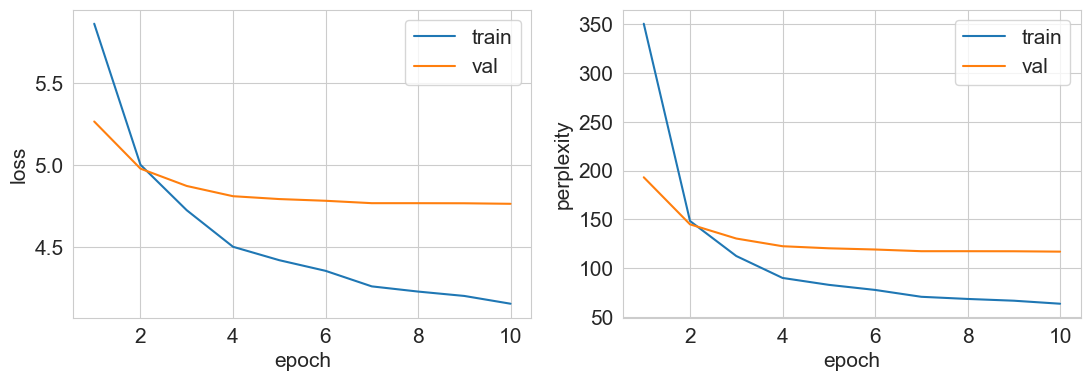

In [87]:
train(
    model_bpe_large,
    optimizer,
    scheduler,
    train_loader_bpe_large,
    val_loader_bpe_large,
    num_epochs=num_epochs,
    device=device
)

In [88]:
torch.save(model, "./lstm_bpe_10000_model.pt")

### Unigram - 10000 vocab

In [89]:
train_set_unigram = TextDataset(data_file='jokes.txt', train=True, model_type='unigram', sp_model_prefix='unigram_10000', vocab_size=10000)
valid_set_unigram = TextDataset(data_file='jokes.txt', train=False, model_type='unigram', sp_model_prefix='unigram_10000', vocab_size=10000)

In [90]:
model_unigram = LanguageModel(train_set_unigram, rnn_type=nn.LSTM)

In [91]:
learning_rate = 0.001
batch_size = 32
num_epochs = 10

In [92]:
optimizer = optim.Adam(model_unigram.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

In [93]:
train_loader_unigram = DataLoader(train_set_unigram, batch_size=batch_size, shuffle=True)
val_loader_unigram = DataLoader(valid_set_unigram, batch_size=batch_size)

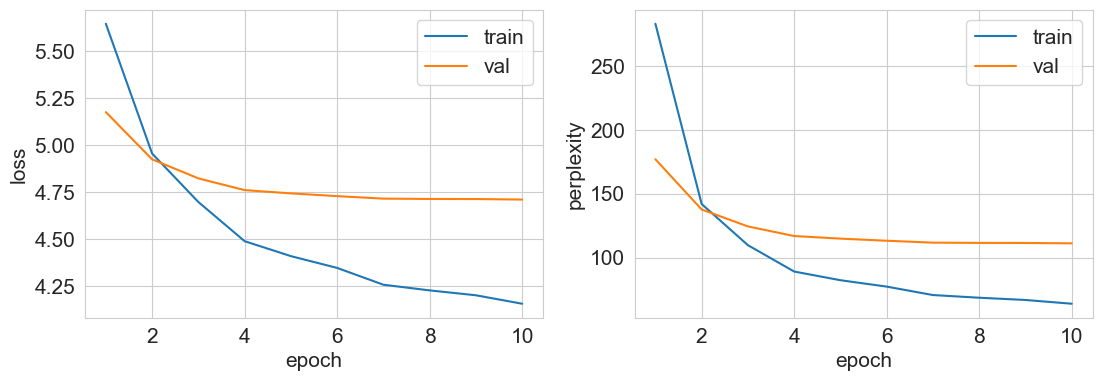

In [94]:
train(
    model_unigram,
    optimizer,
    scheduler,
    train_loader_unigram,
    val_loader_unigram,
    num_epochs=num_epochs,
    device=device
)

In [95]:
torch.save(model, "./lstm_unigram_10000_model.pt")

### Unigram - 2000 vocab

In [96]:
train_set_unigram_2000 = TextDataset(data_file='jokes.txt', train=True, model_type='unigram', sp_model_prefix='unigram_2000')
valid_set_unigram_2000 = TextDataset(data_file='jokes.txt', train=False, model_type='unigram', sp_model_prefix='unigram_2000')

In [97]:
model_unigram_2000 = LanguageModel(train_set_unigram_2000, rnn_type=nn.LSTM)

In [98]:
learning_rate = 0.001
batch_size = 32
num_epochs = 10

In [99]:
optimizer = optim.Adam(model_unigram_2000.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

In [101]:
train_loader_unigram_2000 = DataLoader(train_set_unigram_2000, batch_size=batch_size, shuffle=True)
val_loader_unigram_2000 = DataLoader(valid_set_unigram_2000, batch_size=batch_size)

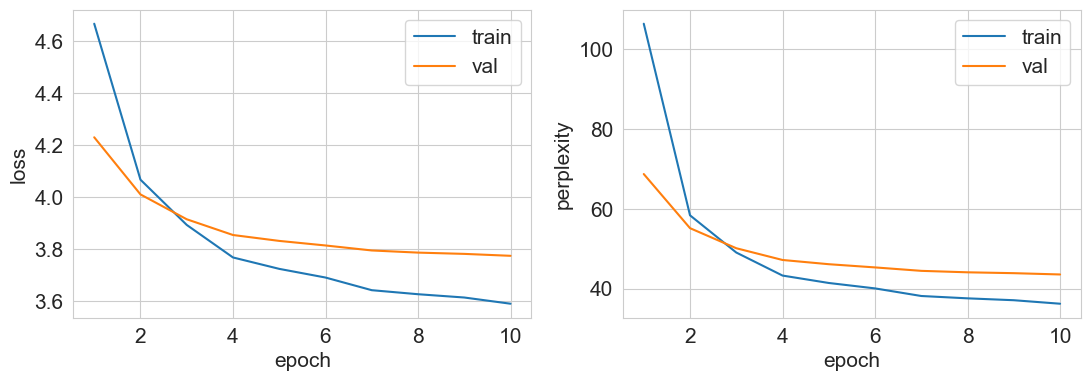

In [102]:
train(
    model_unigram_2000,
    optimizer,
    scheduler,
    train_loader_unigram_2000,
    val_loader_unigram_2000,
    num_epochs=num_epochs,
    device=device
)

In [103]:
torch.save(model, "./lstm_unigram_2000_model.pt")

### Генерация

#### Unigram_2000

In [104]:
model_unigram_2000 = torch.load("lstm_unigram_2000_model.pt").to(torch.device("cpu"))

In [105]:
model_unigram_2000.inference(prefix_eco, temp=0.1)

'экономический рывок был настолько мощным, а пенсия чиновника...'

In [110]:
model_unigram_2000.inference(prefix_eco, temp=0.1)

'экономический рывок был настолько мощным, потому что одновременно до нагрывы первый какие-то сильно алкоголик...'

#### Unigram_10000

In [106]:
model_unigram_10000 = torch.load("lstm_unigram_10000_model.pt").to(torch.device("cpu"))

In [107]:
model_unigram_10000.inference(prefix_eco, temp=0.1)

'экономический рывок был настолько мощным, постоянно убедилась!'

In [111]:
model_unigram_10000.inference(prefix_eco, temp=0.1)

'экономический рывок был настолько мощным, чтобы тебя пока носить - трездами.- ну, вот, там нет джор, а она была подня!.'

#### BPE_10000

In [108]:
model_bpe_large = torch.load("lstm_bpe_10000_model.pt").to(torch.device("cpu"))

In [109]:
model_bpe_large.inference(prefix_eco, temp=0.1)

'экономический рывок был настолько мощным, народ все-таки заботы. пора, где жена ее спрашивает своего кофе и мимо уже давно.'

In [112]:
model_bpe_large.inference(prefix_eco, temp=0.1)

'экономический рывок был настолько мощным, если бы я разблоки очередное место.'

- Генерации у трех моделей такие же бессмысленные, как и у bpe_2000, однако лучше всего получилось у unigram_2000 (в каком-то месте даже немного смешно про чиновника); 
- По perplexity не совсем корректно оценивать предсказательную способность моделей, так как разные токенизаторы формируют разные наборы токенов, что приводит к различным разбиениям текста на токены:
$$PPL(X)=\exp\{−\frac{1}{t}​\sum\limits_{i}^{t}​\log{p_θ}​(x_i​∣x_{<i}​)\}$$

где $x_i$ - $i$-й токен,
$x_{<i}$ - предшествующий $i$-ому токену набор токенов

Разные токенизаторы (например, BPE с большим числом токенов и пословный токенизатор unigram) разрезают текст на разные количества и виды токенов. BPE может разбить слово "perplexity" на токены "per", "plex", "ity", тогда как unigram оставит его как единый токен "university", так как токены различаются, вероятности предсказания этих токенов также будут различаться. Модели будут обучены на предсказание разных токенов, что приведет к различным значениям логарифмов вероятностей $log p_{\theta}(x_{i} | x_{<i})$.

## Задание 7. Latent Semantic Analysis (1 балл)

Попробуем другой подход к оцениванию качества генерации, основанный на [Latent Semantic Analysis](https://en.wikipedia.org/wiki/Latent_semantic_analysis). Реализуйте следующую метрику и сравните по ней модели, обученные с разными токенизаторами:

1. Генерируем обученной моделью выборку текстов, совпадающую по размеру с валидационной выборкой.
2. Объединяем две выборки текстов (валидационную и сгенерированную) в один корпус. Обратите внимание, что наша токенизация в общем случае необратима, поэтому для чистоты эксперимента нужно закодировать и декодировать валидационную выборку.
3. Генерируем tf-idf матрицу для полученного корпуса.
4. Понижаем размерность матрицы с помощью [SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).
5. Теперь у нас есть векторы, описывающие валидационные и сгенерированные тексты, лежащие в одном пространстве. Для каждого вектора, отвечающего сгенерированному тексту, найдем наибольший cosine similarity между ним и вектором валидационного текста. Усредним такие similarity по всем сгенерированным текстам и получим число, характеризующее похожесть сгенерированной выборки на валидационную.

Какие плюсы и минусы есть у описанной метрики?

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import torch
from sklearn.metrics.pairwise import cosine_similarity

def get_validation_texts(val_loader, sp_model):
    validation_texts = []
    for batch in val_loader:
        encoded_texts, lengths = batch
        for encoded_text in encoded_texts:
            text = sp_model.decode(encoded_text.tolist())
            validation_texts.append(text)
    return validation_texts

def generate_texts(model, validation_texts):
    generated_texts = []
    for text in validation_texts:
        # Получаем первые три слова из текста валидационной выборки для дальнейшей генерации
        prefix = ' '.join(text.split()[:3])
        generated_text = model.inference(prefix=prefix)
        generated_texts.append(generated_text)
    return generated_texts

def get_tfidf_matrix(texts):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(texts)
    return tfidf_matrix

def apply_svd(tfidf_matrix, n_components=100):
    svd = TruncatedSVD(n_components=n_components)
    svd_matrix = svd.fit_transform(tfidf_matrix)
    return svd_matrix

def calculate_similarity(validation_texts, generated_texts):
    vectorizer = TfidfVectorizer()
    all_texts = validation_texts + generated_texts
    tfidf_matrix = vectorizer.fit_transform(all_texts)

    validation_matrix = tfidf_matrix[:len(validation_texts)]
    generated_matrix = tfidf_matrix[len(validation_texts):]

    similarities = cosine_similarity(generated_matrix, validation_matrix)
    max_similarities = similarities.max(axis=1)
    mean_similarity = max_similarities.mean()
    return mean_similarity


- Метрика позволяет оценить способность модели генерировать тексты с семантически похожими словами на те, которые присутствуют в валидационной выборке;
- Метрика учитывает семантическое сходство по словам и их вхождению, но не учитывает порядок слов или синтаксическую структуру предложений. Это может привести к ситуации, когда сгенерированный текст содержит те же слова, но не имеет смысла или логической последовательности;
- Результаты метрики могут значительно изменяться в зависимости от состава и разнообразия валидационной выборки;
- TF-IDF и SVD оперируют с более абстрактными признаками, метрика может упустить порядок слов, семантические связи между ними.

В задании по визуализации рассчитана метрика для 3 моделей и проведены сравнения.

## Задание 8. Visualization (1 балл)

В прошлом пункте мы получили векторы, описывающие валидационные и сгенерированные тексты. Попробуем визуализировать их. Примените [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) к этим векторам и нарисуйте scatter-plot с получившимися двумерными представлениями. Точки, соответствующие валидационным и сгенерированным текстам, должны быть разного цвета. Визуализируйте таким образом все три модели для разных токенизаторов. 

In [23]:
def visualize(tsne_result, labels, title):
    plt.figure(figsize=(10, 7))
    for label in np.unique(labels):
        idx = labels == label
        plt.scatter(tsne_result[idx, 0], tsne_result[idx, 1], label=label, alpha=0.5)
    plt.legend()
    plt.title(title)
    plt.show()
    
def apply_tsne(svd_matrix, n_components=2):
    tsne = TSNE(n_components=n_components, random_state=42)
    tsne_result = tsne.fit_transform(svd_matrix)
    return tsne_result

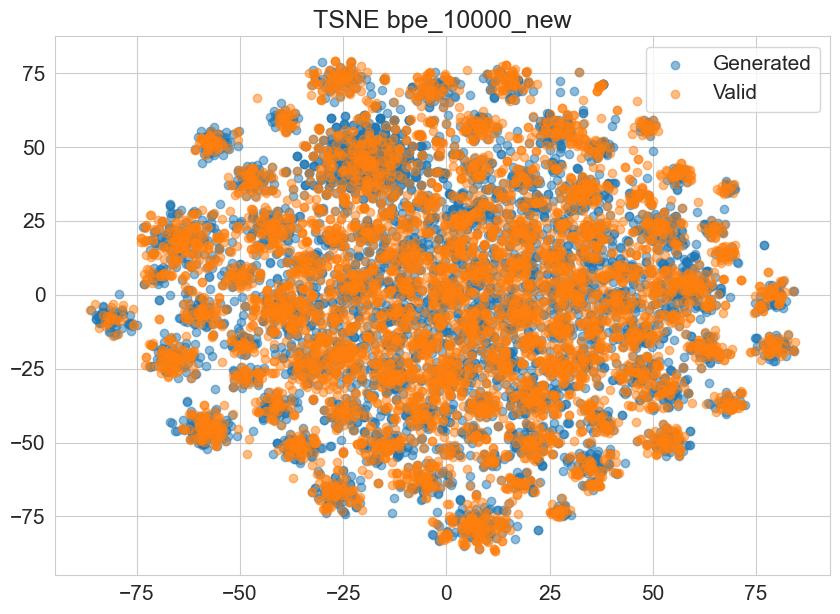

Схожесть сгенерированной выборки на валидационную bpe_10000_new: 0.25272786724782914


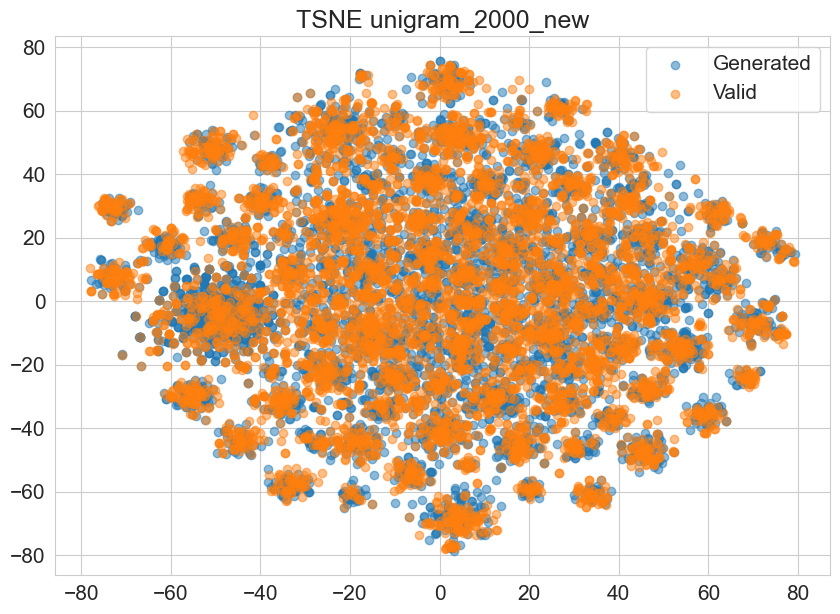

Схожесть сгенерированной выборки на валидационную unigram_2000_new: 0.2506530144335804


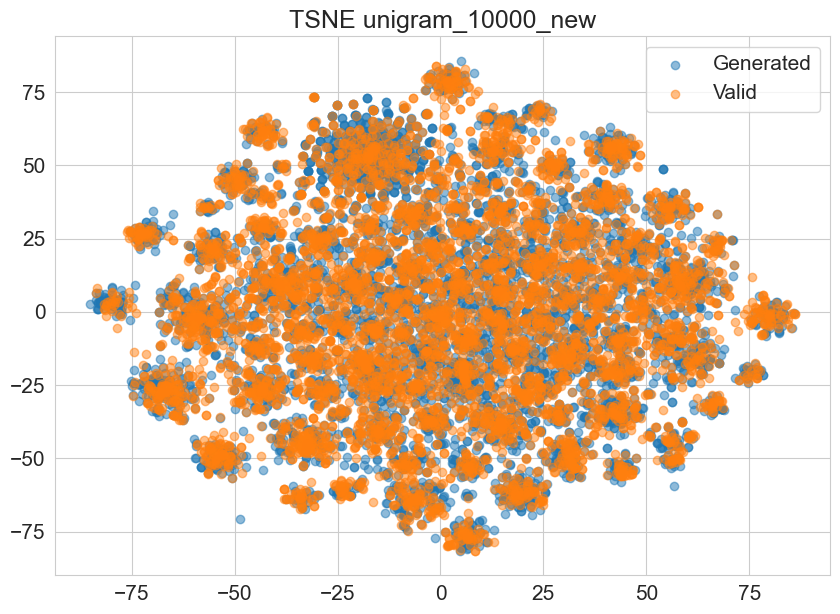

Схожесть сгенерированной выборки на валидационную unigram_10000_new: 0.2532647363989957


In [24]:
models = ["./lstm_bpe_10000_model.pt", "./lstm_unigram_10000_model.pt", "./lstm_unigram_2000_model.pt"]
tokenizers = ["bpe_10000_new", "unigram_2000_new", "unigram_10000_new"]
    
for model_path, tokenizer_prefix in zip(models, tokenizers):
        model_type = tokenizer_prefix.split('_')[0]
        
        # Загрузка модели и датасета
        dataset = TextDataset(data_file='jokes.txt', sp_model_prefix=tokenizer_prefix, model_type=model_type)
        model = torch.load(model_path)
        
        # Создание валидационного датасета и загрузчика
        val_dataset = TextDataset(data_file='jokes.txt', sp_model_prefix=tokenizer_prefix, model_type=model_type, train=False)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
        
        # Получение текстов из валидационного загрузчика
        validation_texts = get_validation_texts(val_loader, val_dataset.sp_model)
        
        # Генерация текстов на основе валидационных текстов
        generated_texts = generate_texts(model, validation_texts)
        
        # Объединение текстов для TF-IDF и SVD
        all_texts = validation_texts + generated_texts
        
        # Получение TF-IDF матрицы
        tfidf_matrix = get_tfidf_matrix(all_texts)
        
        # Применение SVD
        svd_matrix = apply_svd(tfidf_matrix)
        
        # Применение TSNE для визуализации
        tsne_result = apply_tsne(svd_matrix)
        
        # Создание меток для визуализации
        labels = np.array(['Valid'] * len(validation_texts) + ['Generated'] * len(generated_texts))
        
        # Визуализация с помощью TSNE
        visualize(tsne_result, labels, f"TSNE {tokenizer_prefix}")

        # Вычисление и вывод метрики сходства
        mean_similarity = calculate_similarity(validation_texts, generated_texts)
        print(f"Схожесть сгенерированной выборки на валидационную {tokenizer_prefix}: {mean_similarity}")

Как можно заметить, метрика +- одинакова для всех 3 моделей и имеет низкое значение (~0.25). В целом, это видно по генерации бессвязных текстов из прошлых заданий.

## Бонус (0.1 балл)

Покажите лучший анекдот, который удалось сгенерировать вашей модели. Если проверяющий найдет его смешным, то поставит 0.1 балла.

(